In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
import findspark
findspark.init()

spark-3.0.2-bin-hadoop2.7/
spark-3.0.2-bin-hadoop2.7/R/
spark-3.0.2-bin-hadoop2.7/R/lib/
spark-3.0.2-bin-hadoop2.7/R/lib/sparkr.zip
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/worker/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/worker/worker.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/worker/daemon.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/tests/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/tests/testthat/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/tests/testthat/test_basic.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/profile/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/profile/shell.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/profile/general.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/sparkr-vignettes.html
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/sparkr-vignettes.Rmd
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/sparkr-vignettes.R
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/doc/index.html
spark-3.0.2-bin-hadoop2.7/R/lib/SparkR/R/
spark-3.0.2-

# Data Exploration and Visualization

In [2]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt


spark = SparkSession.builder.getOrCreate()

In [ ]:
spark.read.csv("MsNPC.csv", header=True).createOrReplaceTempView("npcs")
spark.read.csv("MsPlayer.csv", header=True).createOrReplaceTempView("players")
spark.read.csv("MsWeapon.csv", header=True).createOrReplaceTempView("weapons")
spark.read.csv("MsWeaponType.csv", header=True).createOrReplaceTempView("weapon_types")
spark.read.csv("TransactionDetail.csv", header=True).createOrReplaceTempView("transaction_details")
spark.read.csv("TransactionHeader.csv", header=True).createOrReplaceTempView("transaction_headers")

In [ ]:
spark.sql("select * from players").show()

+--------+-----------------+------------+----------+
|PlayerId|       PlayerName|PlayerGender| PlayerDOB|
+--------+-----------------+------------+----------+
|       1|      Janos Hasel|        Male|2001-12-25|
|       2|      Barty Kayne|        Male|1999-05-17|
|       3|     Pattin Maron|        Male|2000-02-25|
|       4|  Steffane Gandar|      Female|2001-01-06|
|       5|  Isobel Ferryman|      Female|1999-03-19|
|       6|Dorothea Nockells|      Female|1996-06-14|
|       7|    Humphrey Ivan|        Male|1998-12-04|
|       8|     Nikki Lambie|        Male|1995-09-07|
|       9|  Karney Da Costa|        Male|2000-01-12|
|      10|     Weylin Jakel|        Male|1998-06-27|
|      11|  Keriann Arnolds|      Female|2000-02-16|
|      12|        Liz Acock|      Female|1997-03-30|
|      13|  Emmeline Ferreo|      Female|1997-03-06|
|      14|     Billye Dudin|      Female|1997-12-11|
|      15|    Jobie Volkers|      Female|1999-08-06|
|      16|   Vernice Antrum|      Female|1995-

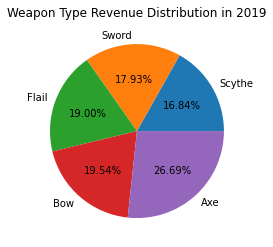

In [ ]:
# a.	Show the percentage of weapon type sold for weapon type that is sold in 2019 using pie plot.
import matplotlib.pyplot as plt
data = spark.sql("""
  SELECT wt.weapontypename, SUM(w.weaponprice * td.quantity) as revenue 
  FROM weapon_types wt JOIN weapons w
  on wt.weapontypeid = w.weapontypeid JOIN transaction_details td
  on w.weaponid = td.weaponid JOIN transaction_headers th
  on td.transactionid = th.transactionid
  WHERE year(th.transactiondate) = 2019
  group by wt.weapontypename
  order by revenue

""").toPandas()

plt.pie(data["revenue"], labels=data["weapontypename"], autopct="%.2f%%")
plt.title("Weapon Type Revenue Distribution in 2019")
plt.show()

# display(data)

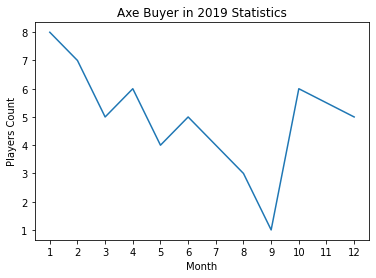

In [ ]:
#Show the total number of players who bought axe weapon type 
#per month in 2019 using line plot. Multiple transaction within the same month will be counted as 1.

#distinct untuk multiple transaction yg id sama hitung 1

#.show()
import matplotlib.pyplot as plt
data = spark.sql("""
  SELECT COUNT(distinct th.playerid) as Count, MONTH(th.transactiondate) as Month
  FROM transaction_headers th JOIN transaction_details td
  on td.transactionid = th.transactionid JOIN weapons w
  on w.weaponid = td.weaponid JOIN weapon_types wt
  on w.weapontypeid = wt.weapontypeid
  WHERE year(th.transactiondate) = 2019 
    and wt.weapontypename='Axe'
  group by MONTH(th.transactiondate)
  order by MONTH(th.transactiondate)

""").toPandas()

plt.plot(data["Month"], data["Count"])
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Players Count")
plt.title("Axe Buyer in 2019 Statistics")
plt.show()

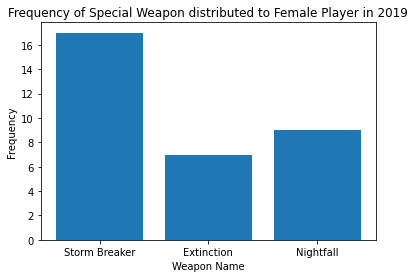

In [ ]:
#Show the frequency of special weapon being distributed to female players in 2019 using bar plot. The
#player will receive special weapon if their monthly spending reached this following condition: 

import matplotlib.pyplot as plt
data = spark.sql("""
  select SpecialWeapon, count(*) as count
  from (
  SELECT p.playerid, sum(w.weaponprice * td.quantity) as spending,
    case
      when sum(w.weaponprice * td.quantity) between 1000000 and 1499999 then 'Storm Breaker'
      when sum(w.weaponprice * td.quantity) between 1500000 and 1999999 then 'Nightfall'
      when sum(w.weaponprice * td.quantity) > 2000000 then 'Extinction'
    end as SpecialWeapon
  FROM players p JOIN transaction_headers th on p.playerid = th.playerid
  JOIN transaction_details td on td.transactionid = th.transactionid 
  JOIN weapons w on w.weaponid = td.weaponid
  WHERE p.playergender='Female' 
    and year(th.transactiondate) = 2019
  group by p.playerid, MONTH(th.transactiondate) 
) 
where specialweapon is not NULL
group by specialweapon
""").toPandas()

plt.bar(data["SpecialWeapon"], data["count"])
plt.xlabel("Weapon Name")
plt.ylabel("Frequency")
plt.title("Frequency of Special Weapon distributed to Female Player in 2019")
plt.show()

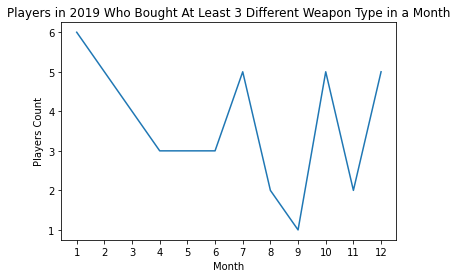

In [ ]:
#Show total number of players per month in 2019 who bought at 
#least 3 different weapon type in a month using line plot.

import matplotlib.pyplot as plt
data = spark.sql("""
SELECT count(*) as playerCount, Month
FROM (
  SELECT th.playerid, COUNT(distinct w.weapontypeid) as count, MONTH(th.transactiondate) as Month
  FROM transaction_headers th JOIN transaction_details td
  on td.transactionid = th.transactionid JOIN weapons w
  on w.weaponid = td.weaponid 
  WHERE year(th.transactiondate) = 2019 
  group by MONTH(th.transactiondate), th.playerid
  having COUNT(distinct w.weapontypeid) >=3
) 
group by Month
order by Month
""").toPandas()

plt.plot(data["Month"], data["playerCount"])
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Players Count")
plt.title("Players in 2019 Who Bought At Least 3 Different Weapon Type in a Month")
plt.show()

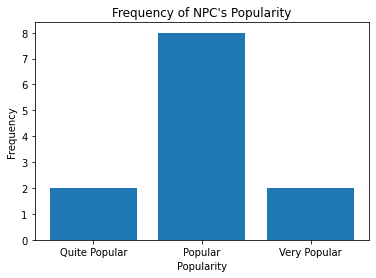

In [ ]:
# e.	Show the frequency of NPC's popularity who has done at least transaction with 5 different player using bar plot. 
# The popularity is determined based on the total income made by the NPC as follows:
# Popularity	Total Income
# Very Popular	>= 15,000,000
# Popular	>= 7,500,000 – 14,999,999
# Quite Popular	>= 2,500,000 – 7,499,999
# Not Popular	< 2,500,000



import matplotlib.pyplot as plt
data = spark.sql("""
select Popularity, count(*) as Frequency
  from (
  SELECT n.npcid, COUNT(p.playerid) as count, sum(w.weaponprice * td.quantity) as income,
  case
      when sum(w.weaponprice * td.quantity) >= 15000000 then 'Very Popular'
      when sum(w.weaponprice * td.quantity) between 7499999 and 15000000 then 'Popular'
      when sum(w.weaponprice * td.quantity) between 2499999 and 7500000 then 'Quite Popular'
      when sum(w.weaponprice * td.quantity) < 2500000 then 'Not Popular'
    end as Popularity
  FROM players p JOIN transaction_headers th on p.playerid = th.playerid
  JOIN npcs n on th.npcid = n.npcid
  JOIN transaction_details td on td.transactionid = th.transactionid 
  JOIN weapons w on w.weaponid = td.weaponid
  group by n.npcid 
  having COUNT(distinct p.playerid) >=5
  )
  where Popularity is not NULL
  group by Popularity

""").toPandas()

plt.bar(data["Popularity"], data["Frequency"])
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.title("Frequency of NPC's Popularity")
plt.show()

# Data Clustering

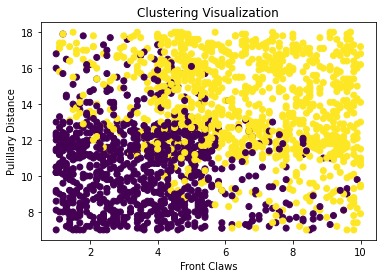

Accuracy: 83.5%


In [24]:
testing = spark.read.csv("BearTesting.csv", header=True, inferSchema=True)
training = spark.read.csv("BearTraining.csv", header=True, inferSchema=True)

columns = ["Front Claws", "Pupillary Distance", "Ear Shape"]

testing = testing.na.drop()
training = training.na.drop()

testing = testing.select("Front Claws", "Pupillary Distance", "Ear Shape", "Grizzly")
training = training.select(columns)

from pyspark.sql.functions import when
#otherwise(2) = .when yg paling akhir
testing = testing.withColumn(
    "Ear Shape",
    when (testing ["Ear Shape"]=="Pointed", 0)
    .when (testing ["Ear Shape"]=="Broad", 1)
    .otherwise(2)
)

testing = testing.withColumn(
    "Grizzly",
    when (testing ["Grizzly"]=="No", 0)
    .otherwise(1)
)

training = training.withColumn(
    "Ear Shape",
    when (training ["Ear Shape"]=="Pointed", 0)
    .when (training ["Ear Shape"]=="Broad", 1)
    .otherwise(2)
)

from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler = VectorAssembler(inputCols=columns, outputCol="assembled")
scaler = StandardScaler(inputCol="assembled", outputCol="features")

testing = assembler.transform(testing)
training = assembler.transform(training)

testing = scaler.fit(testing).transform(testing)
training = scaler.fit(training).transform(training)

from pyspark.ml.clustering import KMeans

#seed=1 tambahan
kmeans = KMeans(k=2, seed=1)
model = kmeans.fit(training)
data = model.transform(testing)
data = data.toPandas()

plt.scatter(
    data["Front Claws"],
    data["Pupillary Distance"],
    c=data["prediction"]
)

plt.title("Clustering Visualization")
plt.xlabel("Front Claws")
plt.ylabel("Pulillary Distance")
plt.show()

c = 0
for idx, row in data.iterrows():
   if row["Grizzly"] == row["prediction"]: c += 1

acc = c /len(data) * 100
print(f'Accuracy: {acc}%')

